In [121]:
### dependencies ###
# !pip install cvxpy
# !pip install mystic

In [122]:
%matplotlib inline

# import cvxpy as cp
import numpy as np

import scipy.optimize as opt

import random
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [123]:
# # verify runway plot

# t_sim = 10 # seconds

# center_line_x = np.zeros((t_sim,))
# left_boundary_x = np.ones((t_sim,)) * -10
# right_boundary_x = np.ones((t_sim)) * 10

# center_line_y = np.linspace(0, t_sim, t_sim)
# left_boundary_y = np.linspace(0, t_sim, t_sim)
# right_boundary_y = np.linspace(0, t_sim, t_sim)

# plt.figure(figsize=(20, 3))
# plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
# plt.plot(left_boundary_y, left_boundary_x, color='black')
# plt.plot(right_boundary_y, right_boundary_x, color='black')

In [254]:
### function to plot trajectory ###

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]

def plot_trajectory(states, angle=0, runway_length=(-100, 100), runway_boundaries=(-10, 10), verbose=False):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, _, _, _ = states[i:i+6]
        x, y = rotate(x, y, angle)
        if verbose:
            print(x, y)
        plt.plot(x, y, marker='o', markersize=5, color=colors[int(i//6)])   

### print states after getting result ###
        
def print_states(states):
    for i in range(0, len(states), 6):
        print("state {}:".format(int(i//6) + 1))
        output_states = np.round(states[i:i+6], 5)
        print("\tx: {}, y: {}, velocity: {}, heading: {}\n\tacceleration: {}, angular velocity: {}\n".\
              format(output_states[0], output_states[1], output_states[2], output_states[3], 
                     output_states[4], output_states[5]))

In [125]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.array([rho, phi])

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.array([x, y])

In [314]:
def rejection_dist(centerline, curr_x, curr_y):
    pt = np.array([curr_x, curr_y])
    projection = centerline@pt / np.linalg.norm(centerline, ord=2) ** 2 * centerline
    proj_x, proj_y = projection
    sign = math.copysign(1, curr_x - proj_x)
    return sign * np.linalg.norm([curr_x - proj_x, curr_y - proj_y], ord=2)

***States and Parameters Setup***

In [126]:
# ### states setup ###

# init_heading = 90 # degrees
# init_velocity = 0 # m/s

# init_acceleration = 0 # m/s^2
# init_turning = 0 # degrees/s

# # start here at t = 0
# init_x = 0
# init_y = 0

# # want to end here at t = sim_time
# desired_x = 0
# desired_y = 100

# desired_velocity = 30 # m/s

# acceleration_constraint = 5 # m/s^2
# turning_constraint = 60 # degrees

# time_step = 1
# sim_time = 10

# guess_range = (0, 10)

***Controller Optimzed Without Direct Positional State***

In [345]:
### xplane test states setup ###

zero_heading = 270
runway_heading = 54.331

init_heading = zero_heading + runway_heading # degrees
init_velocity = 0 # m/s

init_velocity_x = 0 # m/s
init_velocity_y = 0 # /s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 23
init_y = -50

# want to end here at t = sim_time
desired_x = 2421
desired_y = -1737

desired_velocity = 30 # m/s

acceleration_constraint = 7 # m/s^2
turning_constraint = 10 # degrees

time_step = 1
sim_time = 10

num_environment_samples = 10
windspeed_lb = 0
windspeed_ub = 20
windheading_lb = runway_heading - 30 + zero_heading
windheading_ub = runway_heading + 30 + zero_heading

wind_dynamics = [(np.random.randint(windspeed_lb, windspeed_ub + 1), \
                  np.random.randint(windheading_lb, windheading_ub + 1)) \
                  for _ in range(num_environment_samples)]

plane_cs = 27.41 # square meters
plane_mass = 6175 * 0.45359237 # lbs -> kg
plane_half_length = 10.82 / 2

plane_specs = [plane_cs, plane_mass, plane_half_length]

-27.21747926998831
-15.866462913967702 -22.11439649667001
0.0


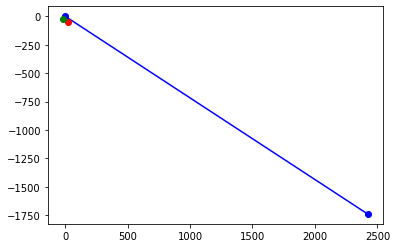

In [346]:
plt.figure()
plt.plot([0, desired_x], [0, desired_y], 'bo-')
plt.plot(init_x, init_y, 'ro')

cl = np.array([desired_x, desired_y])
d = rejection_dist(cl, init_x, init_y)
print(d)

test_x, test_y = rotate(0, d, np.degrees(np.arctan([desired_y / desired_x]))[0])

print(test_x, test_y)
print(np.dot([test_x, test_y], [desired_x, desired_y]))

plt.plot(test_x, test_y, 'go')

In [347]:
def compute_states(init_state, controls, wind_dynamics, plane_specs, time_step=1):
    
    wind_speed, wind_heading = wind_dynamics
    plane_cs, plane_mass, plane_half_length = plane_specs
    wind_force = wind_speed * plane_cs
    wind_acc = wind_force / plane_mass
    
    states = []
    x, y, v, h = init_state

    for i in range(0, len(controls), 2):
        
        a, w = controls[i:i+2]
        states = np.concatenate((states, [x, y, v, h, a, w]))
        
        vx = (v * np.cos(np.radians(h))) + (time_step * wind_acc * np.cos(np.radians(wind_heading)))
        vy = (v * np.sin(np.radians(h))) + (time_step * wind_acc * np.sin(np.radians(wind_heading)))
        
        x += time_step * vx
        y += time_step * vy
        
        # rF * sin(theta)
        wind_torque = plane_half_length * wind_force * np.sin(np.radians(wind_heading - h))
        wind_torque = np.abs(wind_torque)
        wind_w = 0.1 * time_step * (wind_torque / plane_mass) * plane_half_length
        v += time_step * a
        h += time_step * (w + wind_w)
        
        h %= 360

    return states


def formulate_objective(init_state, center_line, desired_states, environment, plane_specs, time_step=1):
    
    control_weight = 0.1
    centerline_weight = 100
    velocity_weight = 3
    heading_weight = 5
    
    desired_h, desired_v = desired_states
    
    def objective(params):
        cost = 0        
        for env in environment:
            states = compute_states(init_state, params, env, plane_specs, time_step=time_step)
            for i in range(6, len(states), 6):
                px, py, v, h, a, w = states[i:i+6]
                cost += centerline_weight * np.abs(rejection_dist(center_line, px, py))
                cost += velocity_weight * np.linalg.norm([desired_v - v], ord=2)
                cost += heading_weight * np.linalg.norm([desired_h - h], ord=2)
        return cost / len(environment)
    
    return objective


def formulate_guess(sim_time):
    return np.zeros((sim_time*2,))
    
    
init_guess = formulate_guess(sim_time)
bounds = [(-acceleration_constraint, acceleration_constraint), 
          (-turning_constraint, turning_constraint)] * sim_time
cl = np.array([desired_x, desired_y])
rinit_x, rinit_y = rotate(0, rejection_dist(cl, init_x, init_y), runway_heading + zero_heading - 360)
state0 = [rinit_x, rinit_y, init_velocity, init_heading]

obj = formulate_objective(state0, cl, [runway_heading + zero_heading, desired_velocity], 
                          wind_dynamics, plane_specs, time_step=time_step)
# consider final heading

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds,
                      options={'eps': 0.3, 'maxiter': 500})
result

     fun: 9898.060368040795
     jac: array([ 22.09052027, 202.90788762,  28.76614238, 204.09796967,
        20.48973922, 190.6848702 ,  12.77223103, 158.05266786,
         9.63366652, 102.73886796,   3.05631031,  55.60061012,
         4.05811151,  21.18166702,  -5.59746104,   2.29534554,
        -3.        ,   5.        ,   0.        ,   0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 1475
     nit: 54
    njev: 50
  status: 0
 success: True
       x: array([ 6.99994985,  9.99993022,  6.99999381,  9.99724641,  6.99999366,
        9.04706928,  3.10230492, -9.9998908 , -6.98745699, -9.99785362,
       -4.13478587, -8.28500392, -6.99998484,  6.01319246,  6.999929  ,
       -9.98668853,  6.99990528,  7.34359705,  0.        ,  0.        ])

state 1:
	x: -15.87056, y: -22.11146, velocity: 324.331, heading: 6.99995

state 2:
	x: 9.99993, y: -15.87056, velocity: 23.19301539977284, heading: 334.33093

state 3:
	x: 6.99999, y: 9.99725, velocity: 26.90025234258036, heading: 13.99994

state 4:
	x: 344.32818, y: 6.99999, velocity: 9.85904000136423, heading: -28.92541

state 5:
	x: 20.99994, y: 353.37525, velocity: 10.470055649427085, heading: 24.77778

state 6:
	x: -31.34809, y: 24.10224, velocity: 343.44644772130226, heading: -9.99785

state 7:
	x: 47.87254, y: -38.24376, velocity: 333.81652676731585, heading: -4.13479

state 8:
	x: -8.285, y: 63.17279, velocity: 47.71257149393229, heading: 325.0925

state 9:
	x: -6.99998, y: 6.01319, velocity: 91.07282660618479, heading: 5.98001

state 10:
	x: 331.10569, y: 6.99993, velocity: 79.68127786987982, heading: -56.23043

state 11:
	x: 12.97994, y: 321.119, velocity: 10.14530438025888, heading: 89.15722

state 12:
	x: -64.378, y: 19.97985, velocity: 328.4626, heading: 0.0



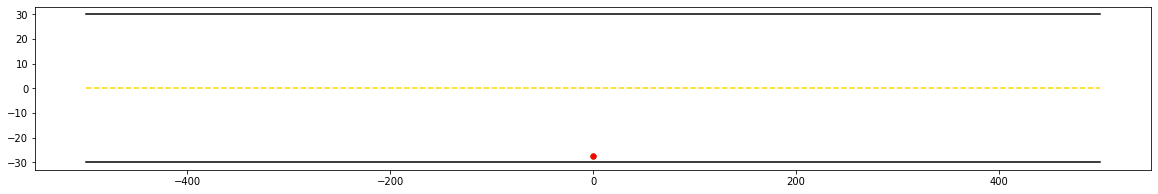

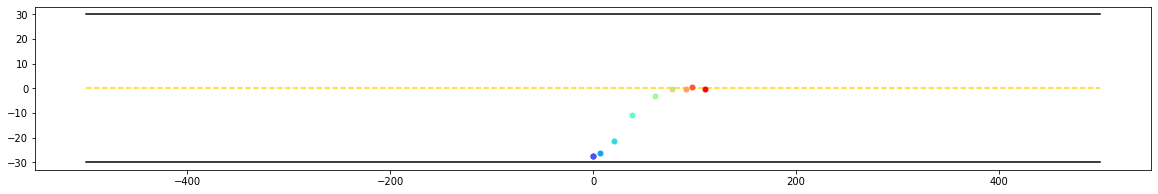

In [348]:
def plot_trajectory(states, angle=0, runway_length=(-100, 100), runway_boundaries=(-10, 10), verbose=False):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, _, _, _ = states[i:i+6]
        x, y = rotate(x, y, angle)
        if verbose:
            print(x, y)
        plt.plot(x, y, marker='o', markersize=5, color=colors[int(i//6)])  

r_runway = -(runway_heading + zero_heading - 360)

guess_traj = compute_states(state0, init_guess, [0, 0], plane_specs)
solved_traj = compute_states(state0, result.x, [0, 0], plane_specs)

plot_trajectory(guess_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(solved_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))

print_states(solved_traj)

***Controller Optimzed Over Controls***

In [313]:
def rejection_dist(cl_x, cl_y, curr_x, curr_y):
    centerline = np.array([cl_x, cl_y])
    pt = np.array([curr_x, curr_y])
    projection = centerline@pt / np.linalg.norm(centerline, ord=2) ** 2 * centerline
    proj_x, proj_y = projection
    sign = math.copysign(1, curr_x - proj_x)
    return sign * np.linalg.norm([curr_x - proj_x, curr_y - proj_y], ord=2)

In [127]:
### xplane test states setup ###

zero_heading = 270
runway_heading = 54.331

init_heading = zero_heading + runway_heading # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0 

# want to end here at t = sim_time
desired_x = 2421
desired_y = -1737

desired_velocity = 30 # m/s

acceleration_constraint = 7 # m/s^2
turning_constraint = 100 # degrees

time_step = 1
sim_time = 8

num_environment_samples = 10
windspeed_lb = 30
windspeed_ub = 40
windheading_lb = runway_heading - 30 + zero_heading
windheading_ub = runway_heading + 30 + zero_heading

wind_dynamics = [(np.random.randint(windspeed_lb, windspeed_ub + 1), \
                  np.random.randint(windheading_lb, windheading_ub + 1)) \
                  for _ in range(num_environment_samples)]

wind_offset = -90
wind_strength = 10

wind_dynamics = [(wind_strength, runway_heading + wind_offset + zero_heading)]

plane_cs = 27.41 # square meters
plane_mass = 6175 * 0.45359237 # lbs -> kg
plane_half_length = 10.82 / 2

plane_specs = [plane_cs, plane_mass, plane_half_length]

In [128]:
def compute_states(init_state, controls, wind_dynamics, plane_specs, time_step=1):
    states = []
    x, y, v, h = init_state
    wind_speed, wind_heading = wind_dynamics
    plane_cs, plane_mass, plane_half_length = plane_specs
    wind_force = wind_speed * plane_cs
    wind_acc = wind_force / plane_mass
    for i in range(0, len(controls), 2):
        a, w = controls[i:i+2]
        states = np.concatenate((states, [x, y, v, h, a, w]))
        vx = (v * np.cos(np.radians(h))) + (time_step * wind_acc * np.cos(np.radians(wind_heading)))
        vy = (v * np.sin(np.radians(h))) + (time_step * wind_acc * np.sin(np.radians(wind_heading)))
#         vx -= time_step * (mu * 9.8 * np.cos(np.radians(h)))
#         vy -= time_step * (mu * 9.8 * np.sin(np.radians(h)))
        
#         vx = (v * np.cos(np.radians(h)))
#         vy = (v * np.sin(np.radians(h)))
        
        x += time_step * vx
        y += time_step * vy
        
#         v, h = pol2cart(v, h) + time_step * (pol2cart(a, w) + pol2cart(wind_acc, wind_heading))
#         v, h = cart2pol(v, h)
        
        # rF * sin(theta)
        wind_torque = plane_half_length * wind_force * np.sin(np.radians(wind_heading - h))
        # ang acc = torque / mass * radius
        wind_w = 0.1 * time_step * (wind_torque / plane_mass) * plane_half_length
        v += time_step * a
        h += time_step * (w + wind_w)
        h %= 360
    return states


def formulate_objective(init_states, desired_states, environment, plane_specs, time_step=1, 
                        state_weight=0.1, control_weight=0.1, constraint_weight=0.1, dstate_weight=0.001, 
                        fvelocity_weight=5):
    desired_x, desired_y, desired_v = desired_states
    def objective(params):
        cost = 0
        for env in environment:
            states = compute_states(init_states, params, env, plane_specs, time_step=time_step)
            cost += control_weight * np.linalg.norm(np.vstack([params[0], params[1]]), ord=2) ** 2
            for i in range(6, len(states) - 6, 6):
                px, py, v, h, a, w = states[i:i+6]
                # closest centerline point
                cost += constraint_weight * rejection_dist(desired_x, desired_y, px, py)
                cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
                cost += state_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
                cost += fvelocity_weight * np.linalg.norm([desired_v - v], ord=2)
            px, py, v, h, a, w = states[-6:]
            cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
            cost += fvelocity_weight * np.linalg.norm([desired_v - v], ord=2)
        return cost / len(environment)
    return objective


def formulate_guess(sim_time):
    return np.zeros((sim_time*2,))
    
    
state0 = [init_x, init_y, init_velocity, init_heading]
init_guess = formulate_guess(sim_time)
bounds = [(-acceleration_constraint, acceleration_constraint), 
          (-turning_constraint, turning_constraint)] * sim_time

obj = formulate_objective(state0, [desired_x, desired_y, desired_velocity], wind_dynamics, plane_specs, time_step=time_step, 
                          state_weight=0, constraint_weight=4, control_weight=0.1, dstate_weight=0, fvelocity_weight=7)
# consider final heading

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds,
                      options={'eps': 0.01, 'maxiter': 3000})
result

     fun: 370.2306075710311
     jac: array([-1.02098024e+01,  1.37186248e-02, -3.19394075e+00,  1.56994005e-02,
        3.81151843e+00,  8.49148619e-03,  1.08120475e+01,  3.31351603e-03,
        1.68119327e+01,  6.95710861e-04,  1.13440163e+01,  7.59196325e-05,
        6.98436995e+00,  7.59196325e-05,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 480
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([ 7.00000000e+00,  9.54134409e-01,  7.00000000e+00,  3.03832130e-01,
        7.00000000e+00, -2.04404742e-03,  7.00000000e+00,  1.25815336e-01,
        1.99862025e+00,  2.09278528e-01, -5.05878788e-04, -4.62040192e-03,
        1.87345377e-03, -4.62040191e-03,  0.00000000e+00,  0.00000000e+00])

state 1:
	x: 0.0, y: 0.0, velocity: 0.0, heading: 324.331
	acceleration: 7.0, angular velocity: 0.95413

state 2:
	x: 0.0, y: 0.0, velocity: 7.0, heading: 325.28513
	acceleration: 7.0, angular velocity: 0.30383

state 3:
	x: 5.75397, y: -3.98645, velocity: 14.0, heading: 325.58897
	acceleration: 7.0, angular velocity: -0.00204

state 4:
	x: 17.30404, y: -11.89821, velocity: 21.0, heading: 325.58692
	acceleration: 7.0, angular velocity: 0.12582

state 5:
	x: 34.62871, y: -23.76647, velocity: 28.0, heading: 325.71274
	acceleration: 1.99862, angular velocity: 0.20928

state 6:
	x: 57.76297, y: -39.54006, velocity: 29.99862, heading: 325.92202
	acceleration: -0.00051, angular velocity: -0.00462

state 7:
	x: 82.6101, y: -56.34891, velocity: 29.99811, heading: 325.9174
	acceleration: 0.00187, angular velocity: -0.00462

state 8:
	x: 107.45546, y: -73.15948, velocity: 29.99999, heading: 325.91278
	acceleration: 0.0, angular velocity: 0.0



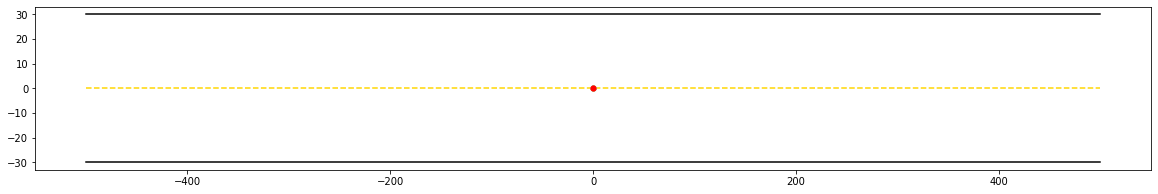

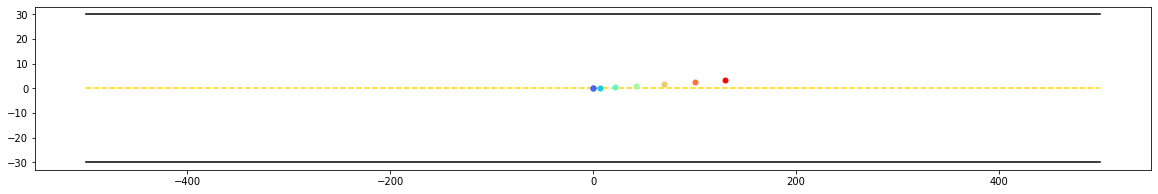

In [129]:
r_runway = -(runway_heading + zero_heading - 360)

guess_traj = compute_states(state0, init_guess, [0, 0], plane_specs)
solved_traj = compute_states(state0, result.x, [0, 0], plane_specs)

plot_trajectory(guess_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(solved_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))

print_states(solved_traj)

***Controller Optimized Over States***

In [12]:
# def shape_states(variables):
#     states = variables[:4]
#     controls = np.concatenate(([0, 0], variables[4:6]))
#     controls[0] = states[2] * np.cos(np.radians(states[3]))
#     controls[1] = states[2] * np.sin(np.radians(states[3]))
#     return states, controls


# def formulate_objective(desired_x, desired_y, desired_v, state_weight=0.1, control_weight=0.1, 
#                         constraint_weight=0.1, dstate_weight=0.001):
#     def objective(params):
#         cost = 0
#         cost += control_weight * np.linalg.norm(np.vstack([params[4], params[5]]), ord=2) ** 2
#         for i in range(6, len(params) - 6, 6):
#             px, py, v, h, a, w = params[i:i+6]
#             cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
#             cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
#             cost += np.linalg.norm([desired_v - v], ord=2) ** 2
#         px, py, v, h, a, w = params[-6:]
#         cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
#         return cost
#     return objective


# def formulate_constraints(state0, sim_time, ts=1):
#     def dynamic_constraints(params):
#         errors = np.zeros((sim_time,))
#         states_t, controls_t = shape_states(state0)
#         errors[0] = np.linalg.norm(params[:4] - states_t, ord=2)
#         for i in range(6, len(params), 6):    
#             states_t1, controls_t1 = shape_states(params[i:i+6])
#             # error[t+1] = norm(x_(t+1) - f(x_t, u_t))
#             errors[int(i // 6)] = np.linalg.norm(states_t1 - (states_t + ts * controls_t), ord=2)
#             states_t, controls_t = states_t1, controls_t1

#         return np.sum(errors)
#     return dynamic_constraints


# def formulate_guess(state0, sim_time, random_seed=0, ts=1):
    
#     guess_a = random.randint(guess_range[0], guess_range[1])
#     guess_w = random.randint(guess_range[0], guess_range[1])
#     state0_controlled = state0 + [guess_a, guess_w]
#     init_state = state0_controlled[:]
#     ix, iy, iv, ih, ia, iw = init_state
    
#     for _ in range(sim_time - 1):
        
#         new_x = ix + ts * iv * np.cos(np.radians(ih))
#         new_y = iy + ts * iv * np.sin(np.radians(ih))
#         new_v = iv + ts * ia
#         new_h = ih + ts * iw
#         guess_a = random.randint(guess_range[0], guess_range[1])
#         guess_w = random.randint(guess_range[0], guess_range[1])
#         init_state += [new_x, new_y, new_v, new_h, guess_a, guess_w]
        
#         ix, iy, iv, ih, ia, iw = new_x, new_y, new_v, new_h, guess_a, guess_w
        
#     return state0_controlled, np.array(init_state)

    
    
# state0 = [init_x, init_y, init_velocity, init_heading]
# state0, init_guess = formulate_guess(state0, sim_time, ts=time_step)

# con = formulate_constraints(state0, sim_time, ts=time_step)
# obj = formulate_objective(desired_x, desired_y, desired_velocity, state_weight=10, 
#                           constraint_weight=1, control_weight=0.5, dstate_weight=10)

# result = opt.minimize(obj, init_guess, method='SLSQP', 
#                       constraints={"fun": con, "type": "eq"},
#                       options={'eps': 0.01, 'maxiter': 1000})
# result

In [11]:
# def get_controls(variables):
#     controls = []
#     for i in range(0, len(variables), 6):
#         controls.append(variables[i+4])
#         controls.append(variables[i+5])
#     return controls

# ### verification for constraints ###

# def verify_output(state0, params, sim_time, ts=1):
#     errors = np.zeros((sim_time,))
#     init_states, init_controls = shape_states(params[:6])
#     errors[0] = np.linalg.norm(params[:4] - init_states, ord=2) ** 2

#     for i in range(6, len(params), 6):    
#         next_states, next_controls = shape_states(params[i:i+6])
#         errors[int(i // 6)] = np.linalg.norm(next_states - (init_states + ts * init_controls), ord=2) ** 2
#         init_states, init_controls = next_states, next_controls

#     return errors

# print("errors:", verify_output(state0, result.x, sim_time, ts=time_step), "\n")

# plot_trajectory(init_guess, runway_length=(-500, 500), runway_boundaries=(-30, 30))
# plot_trajectory(result.x, runway_length=(-500, 500), runway_boundaries=(-30, 30))
        
# print_states(result.x)